Saved sample tolerance inputs: /content/project5_output/tolerance_inputs.csv

--- Risk Summary ---
N_samples: 120000
clearance_mean_mm: 0.012722
clearance_std_mm: 0.025476
clearance_p01_mm: -0.046830
clearance_p05_mm: -0.029272
clearance_p50_mm: 0.012813
clearance_p95_mm: 0.054523
clearance_p99_mm: 0.071082
P_fail: 0.309500
P_pass: 0.690500
Saved summary: /content/project5_output/summary_metrics.csv


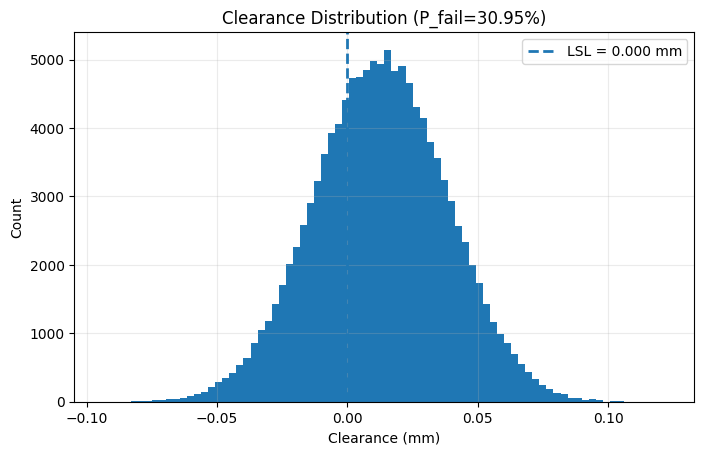


Top drivers by |correlation| with clearance:
            driver  abs_corr_with_clearance
   Housing_Opening                 0.652073
  Module_Thickness                 0.522202
        Shim_Stack                 0.453235
Positional_Closure                 0.232742
    Runout_Closure                 0.162207
  Flatness_Closure                 0.122668


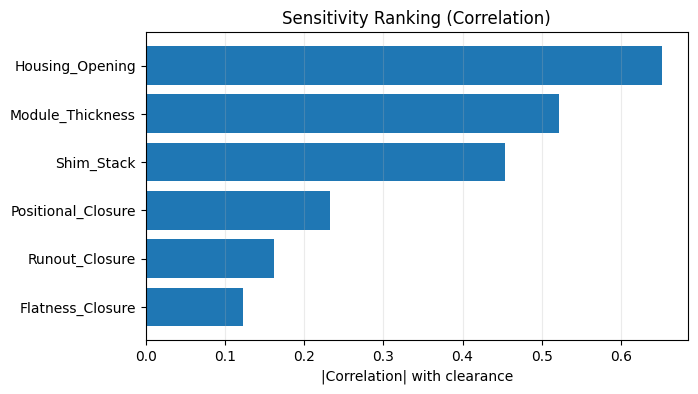


Top drivers by standardized linear coefficient magnitude:
            driver  std_linear_coef
   Housing_Opening         0.016637
  Module_Thickness        -0.013333
        Shim_Stack        -0.011568
Positional_Closure        -0.006019
    Runout_Closure        -0.004013
  Flatness_Closure        -0.003022


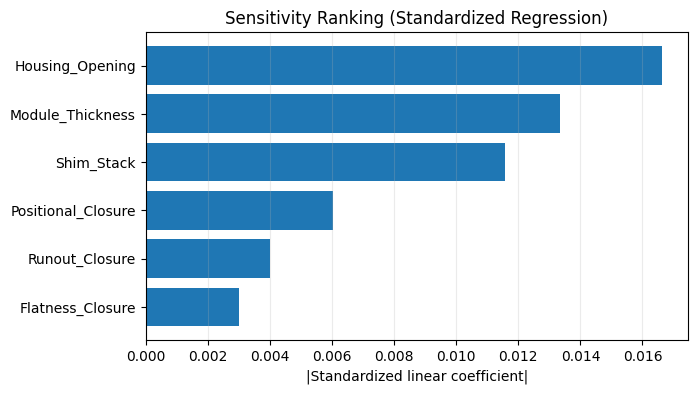


Worst 10 samples (most negative clearance):
 Housing_Opening  Module_Thickness  Shim_Stack  Positional_Closure  Flatness_Closure  Runout_Closure  clearance_mm  fail
        9.945770          9.935710    0.067155            0.014689          0.007048        0.015069     -0.093899     1
        9.938982          9.925605    0.062696            0.027608          0.006937        0.005287     -0.089152     1
        9.960953          9.959281    0.067377            0.010731          0.005981        0.006111     -0.088529     1
        9.959156          9.962119    0.069064            0.010022          0.004310        0.001767     -0.088126     1
        9.941714          9.934665    0.061234            0.012437          0.001066        0.016616     -0.084304     1
        9.935675          9.944415    0.068272            0.000506          0.002231        0.004479     -0.084229     1
        9.961060          9.952718    0.063521            0.012784          0.003720        0.010827     -0.

In [1]:
# ============================================================
# Project 6 — GD&T Tolerance Stack-Up Risk Analyzer (Monte Carlo)
# Colab-ready (CPU).
#
# What it does:
# 1) Generates a sample tolerance input table (can be replaced by your real data)
# 2) Runs Monte Carlo simulation for an assembly critical metric (e.g., clearance)
# 3) Computes risk metrics:
#    - P(fail), P(pass), mean, std, percentiles
#    - "Cpk-like" safety index (optional, approximate)
# 4) Ranks contributors (sensitivity) using correlation + standardized regression
# 5) Exports:
#    - tolerance_inputs.csv
#    - monte_carlo_samples.csv (optional, can be large)
#    - summary_metrics.csv
# ============================================================

!pip -q install numpy pandas matplotlib scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# ----------------------------
# 1) Settings
# ----------------------------
OUT_DIR = "/content/project5_output"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 7
rng = np.random.default_rng(SEED)

N_SAMPLES = 120000   # Monte Carlo samples (100k+ is typical; reduce if needed)
SAVE_SAMPLES_CSV = False  # set True if you want monte_carlo_samples.csv (can be big)

# Failure definition: clearance must be >= 0 (no interference)
CLEARANCE_LOWER_SPEC = 0.0  # mm

# ----------------------------
# 2) Generate sample GD&T / tolerance inputs
#    Replace this table with real part tolerances later.
# ----------------------------
# Example assembly scenario (semiconductor tool / fixture style):
# A critical gap/clearance is formed by a housing and a module stack:
#
#   clearance = (Housing_Opening) - (Module_Thickness) - (Shim_Stack) - (Misalignment_Effect)
#
# We'll model:
# - Dimensional tolerances (normal/uniform)
# - GD&T-like contributors (position/runout/flatness) turned into an "effective" closure term

tol_inputs = pd.DataFrame([
    # name, nominal(mm), tol_plus_minus(mm), distribution, notes
    ["Housing_Opening",      10.000, 0.050, "normal",  "machined pocket width"],
    ["Module_Thickness",      9.920, 0.040, "normal",  "module stack thickness"],
    ["Shim_Stack",            0.050, 0.020, "uniform", "shim selection variation"],
    ["Positional_Error",      0.000, 0.030, "normal",  "GD&T position error (radial)"],
    ["Flatness_Effect",       0.000, 0.015, "normal",  "effective closure from flatness"],
    ["Runout_Effect",         0.000, 0.020, "normal",  "effective closure from runout"],
], columns=["feature", "nominal_mm", "tol_pm_mm", "distribution", "notes"])

# Save inputs
tol_csv = os.path.join(OUT_DIR, "tolerance_inputs.csv")
tol_inputs.to_csv(tol_csv, index=False)
print("Saved sample tolerance inputs:", tol_csv)
tol_inputs


# ----------------------------
# 3) Sampling helpers
# ----------------------------
def sample_feature(nominal, tol_pm, dist, n_samples):
    """
    Sample a tolerance feature.
    - normal: sigma = tol/3  (interpreting ±tol as ~3σ)
    - uniform: uniform in [nominal - tol, nominal + tol]
    """
    nominal = float(nominal)
    tol_pm = float(tol_pm)
    dist = dist.lower().strip()

    if dist == "normal":
        sigma = tol_pm / 3.0
        return rng.normal(loc=nominal, scale=sigma, size=n_samples)
    elif dist == "uniform":
        return rng.uniform(low=nominal - tol_pm, high=nominal + tol_pm, size=n_samples)
    else:
        raise ValueError(f"Unknown distribution: {dist}")

# ----------------------------
# 4) Monte Carlo simulation
# ----------------------------
samples = {}
for _, r in tol_inputs.iterrows():
    samples[r["feature"]] = sample_feature(r["nominal_mm"], r["tol_pm_mm"], r["distribution"], N_SAMPLES)

mc = pd.DataFrame(samples)

# Convert GD&T-like errors into an effective closure term:
# - Positional_Error is modeled as radial magnitude-like; here we already sampled a normal around 0.
#   We treat its absolute value as reducing clearance.
mc["Positional_Closure"] = np.abs(mc["Positional_Error"])

# Flatness/runout effects already sampled around 0; use abs as closure (worst-case direction)
mc["Flatness_Closure"] = np.abs(mc["Flatness_Effect"])
mc["Runout_Closure"] = np.abs(mc["Runout_Effect"])

# Define the critical metric (clearance)
mc["clearance_mm"] = (
    mc["Housing_Opening"]
    - mc["Module_Thickness"]
    - mc["Shim_Stack"]
    - mc["Positional_Closure"]
    - mc["Flatness_Closure"]
    - mc["Runout_Closure"]
)

mc["fail"] = (mc["clearance_mm"] < CLEARANCE_LOWER_SPEC).astype(int)

p_fail = float(mc["fail"].mean())
p_pass = 1.0 - p_fail

summary = {
    "N_samples": int(N_SAMPLES),
    "clearance_mean_mm": float(mc["clearance_mm"].mean()),
    "clearance_std_mm": float(mc["clearance_mm"].std(ddof=1)),
    "clearance_p01_mm": float(np.quantile(mc["clearance_mm"], 0.01)),
    "clearance_p05_mm": float(np.quantile(mc["clearance_mm"], 0.05)),
    "clearance_p50_mm": float(np.quantile(mc["clearance_mm"], 0.50)),
    "clearance_p95_mm": float(np.quantile(mc["clearance_mm"], 0.95)),
    "clearance_p99_mm": float(np.quantile(mc["clearance_mm"], 0.99)),
    "P_fail": p_fail,
    "P_pass": p_pass,
}

summary_df = pd.DataFrame([summary])
summary_csv = os.path.join(OUT_DIR, "summary_metrics.csv")
summary_df.to_csv(summary_csv, index=False)

print("\n--- Risk Summary ---")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")
print("Saved summary:", summary_csv)

# Optional: save samples
if SAVE_SAMPLES_CSV:
    mc_csv = os.path.join(OUT_DIR, "monte_carlo_samples.csv")
    mc.to_csv(mc_csv, index=False)
    print("Saved samples:", mc_csv)

# ----------------------------
# 5) Plot clearance distribution + fail region
# ----------------------------
plt.figure(figsize=(8, 4.8))
plt.hist(mc["clearance_mm"], bins=80)
plt.axvline(CLEARANCE_LOWER_SPEC, linestyle="--", linewidth=2, label=f"LSL = {CLEARANCE_LOWER_SPEC:.3f} mm")
plt.title(f"Clearance Distribution (P_fail={p_fail*100:.2f}%)")
plt.xlabel("Clearance (mm)")
plt.ylabel("Count")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

# ----------------------------
# 6) Sensitivity / contributor ranking
#    Two quick methods:
#    A) Correlation with clearance (higher magnitude => stronger contributor)
#    B) Standardized linear regression coefficients (approx. contribution ranking)
# ----------------------------
# Choose features that directly drive clearance (use closures, not signed)
drivers = pd.DataFrame({
    "Housing_Opening": mc["Housing_Opening"],
    "Module_Thickness": mc["Module_Thickness"],
    "Shim_Stack": mc["Shim_Stack"],
    "Positional_Closure": mc["Positional_Closure"],
    "Flatness_Closure": mc["Flatness_Closure"],
    "Runout_Closure": mc["Runout_Closure"],
})

# A) Correlation
corr = drivers.apply(lambda c: np.corrcoef(c, mc["clearance_mm"])[0, 1])
corr_df = corr.abs().sort_values(ascending=False).reset_index()
corr_df.columns = ["driver", "abs_corr_with_clearance"]
print("\nTop drivers by |correlation| with clearance:")
print(corr_df.to_string(index=False))

plt.figure(figsize=(7, 4))
top = corr_df.iloc[:6][::-1]
plt.barh(top["driver"], top["abs_corr_with_clearance"])
plt.xlabel("|Correlation| with clearance")
plt.title("Sensitivity Ranking (Correlation)")
plt.grid(True, axis="x", alpha=0.25)
plt.show()

# B) Standardized regression (approx. linear sensitivity)
X = drivers.to_numpy()
y = mc["clearance_mm"].to_numpy()

# Standardize X
X_mean = X.mean(axis=0)
X_std = X.std(axis=0, ddof=1)
Xz = (X - X_mean) / (X_std + 1e-12)

lr = LinearRegression()
lr.fit(Xz, y)
coef = lr.coef_

reg_df = pd.DataFrame({
    "driver": drivers.columns,
    "std_linear_coef": coef,
    "abs_std_linear_coef": np.abs(coef),
}).sort_values("abs_std_linear_coef", ascending=False)

print("\nTop drivers by standardized linear coefficient magnitude:")
print(reg_df[["driver", "std_linear_coef"]].to_string(index=False))

plt.figure(figsize=(7, 4))
top2 = reg_df.iloc[:6][::-1]
plt.barh(top2["driver"], top2["abs_std_linear_coef"])
plt.xlabel("|Standardized linear coefficient|")
plt.title("Sensitivity Ranking (Standardized Regression)")
plt.grid(True, axis="x", alpha=0.25)
plt.show()

# ----------------------------
# 7) Alarm-style list: show worst failures (most negative clearance)
# ----------------------------
worst = mc.nsmallest(10, "clearance_mm")[drivers.columns.tolist() + ["clearance_mm", "fail"]]
print("\nWorst 10 samples (most negative clearance):")
print(worst.to_string(index=False))

print("\nOutputs saved in:", OUT_DIR)
print(" - tolerance_inputs.csv")
print(" - summary_metrics.csv")
print("Tip: Replace tolerance_inputs.csv with your real dimensions/GD&T contributors and re-run.")
